# Tracking Nutrition Baby

In [ ]:
!mamba create -n py312 -y
!source /opt/conda/bin/activate py312 && mamba install python=3.12 jupyter mamba -y

!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3
!sudo rm /opt/conda/bin/python3.7 
!sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3.7
!sudo rm /opt/conda/bin/python
!sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python

In [1]:
!python --version

Python 3.12.7


In [2]:
!pip show tf-keras tensorflow

Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: D:\Development\Python\Python312\Lib\site-packages
Requires: tensorflow
Required-by: 
---
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: D:\Development\Python\Python312\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [3]:
!pip install pulp

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import r2_score

In [5]:
from pulp import *
from IPython.display import clear_output

In [6]:
# Load dataset
# df_baby = pd.read_csv('/kaggle/input/nutrition-needed-baby-dataset/kebutuhan_nutrisi_baby_2th.csv')
df_food = pd.read_csv('kaggle/input/data_baby_food1.csv')
# df_food = pd.read_csv('/kaggle/input/data-baby-food-indonesian/data_baby_food.csv')
df_baby = pd.read_csv('kaggle/input/kebutuhan_nutrisi_baby_2th.csv')

In [7]:
print(df_baby.head())
print(df_food.head())

   ID  Usia_Bulan Gender  Berat_Kg  Tinggi_Cm Aktivitas_Level     Status_ASI  \
0   1           0      L       3.5         50          Rendah  ASI_Eksklusif   
1   2           0      P       3.3         49          Rendah  ASI_Eksklusif   
2   3           1      L       4.2         54          Rendah  ASI_Eksklusif   
3   4           1      P       4.0         53          Rendah  ASI_Eksklusif   
4   5           2      L       5.0         58          Rendah  ASI_Eksklusif   

   Kebutuhan_Kalori_Per_Hari  Kebutuhan_Protein_g  Kebutuhan_Lemak_g  \
0                        450                  9.5                 31   
1                        430                  9.0                 30   
2                        480                 10.0                 33   
3                        460                  9.5                 32   
4                        520                 11.0                 36   

   Kebutuhan_Karbohidrat_g Kategori_BB  
0                       48      Normal  
1   

In [8]:
print(df_baby.columns)
print(df_food.columns)

Index(['ID', 'Usia_Bulan', 'Gender', 'Berat_Kg', 'Tinggi_Cm',
       'Aktivitas_Level', 'Status_ASI', 'Kebutuhan_Kalori_Per_Hari',
       'Kebutuhan_Protein_g', 'Kebutuhan_Lemak_g', 'Kebutuhan_Karbohidrat_g',
       'Kategori_BB'],
      dtype='object')
Index(['Age_Group', 'Food (per 100g)', 'Calcium(mg)', 'Protein(g)',
       'Carbohydrate(g)', 'Fat(g)', 'Calorie(kcal)', 'Notes'],
      dtype='object')


In [9]:
# Preprocessing data

df_food = df_food.rename(columns={
    'Food (per 100g)': 'name',
    'Calorie(kcal)': 'calories',
    'Protein(g)': 'proteins',
    'Fat(g)': 'fat',
    'Carbohydrate(g)': 'carbohydrate',
    'Calcium(mg)': 'calcium'
})

# Simpan nilai unik untuk setiap kolom kategorikal sebelum encoding
original_values = {
    'Gender': df_baby['Gender'].unique(),
    'Aktivitas_Level': df_baby['Aktivitas_Level'].unique(),
    'Status_ASI': df_baby['Status_ASI'].unique(),
    'Kategori_BB': df_baby['Kategori_BB'].unique()
}

# Label encoding untuk kolom kategorikal
encoders = {
    'Gender': LabelEncoder(),
    'Aktivitas_Level': LabelEncoder(),
    'Status_ASI': LabelEncoder(),
    'Kategori_BB': LabelEncoder()
}

for column, encoder in encoders.items():
    df_baby[column] = encoder.fit_transform(df_baby[column])

# Pisahkan fitur dan target
feature_columns = ['Usia_Bulan', 'Gender', 'Berat_Kg', 'Tinggi_Cm', 'Aktivitas_Level', 'Status_ASI']
target_columns = ['Kebutuhan_Kalori_Per_Hari', 'Kebutuhan_Protein_g', 'Kebutuhan_Lemak_g', 'Kebutuhan_Karbohidrat_g']

X = df_baby[feature_columns]
y = df_baby[target_columns]

# Normalisasi data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [10]:
# print(df_baby)
# Menampilkan label yang telah diberi angka untuk setiap kolom
for column, encoder in encoders.items():
    print(f'Label untuk {column}:')
    # Menampilkan kategori asli dan nilai encoded-nya
    mapping = dict(zip(original_values[column], encoder.transform(original_values[column])))
    print(mapping)
    print('---')

Label untuk Gender:
{'L': np.int64(0), 'P': np.int64(1)}
---
Label untuk Aktivitas_Level:
{'Rendah': np.int64(1), 'Sedang': np.int64(3), 'Aktif': np.int64(0), 'Sangat_Aktif': np.int64(2)}
---
Label untuk Status_ASI:
{'ASI_Eksklusif': np.int64(1), 'ASI+MPASI': np.int64(0), 'MPASI': np.int64(2)}
---
Label untuk Kategori_BB:
{'Normal': np.int64(0)}
---


In [11]:
print(df_food.head())

    Age_Group                              name  calcium  proteins  \
0   0-6 BULAN                ASI (Air Susu Ibu)       34       1.2   
1   0-6 BULAN       Susu Formula Bayi 0-6 bulan       50       1.5   
2  6-12 BULAN  Susu Formula Lanjutan 6-12 bulan       65       1.8   
3   6-8 BULAN            Bubur Susu Beras Merah       45       3.5   
4   6-8 BULAN            Bubur Susu Beras Putih       40       3.2   

   carbohydrate  fat  calories  \
0           7.0  4.2        70   
1           7.2  3.6        67   
2           8.0  3.8        72   
3          25.0  1.0       123   
4          24.0  0.9       120   

                                               Notes  
0  ASI Eksklusif direkomendasikan oleh WHO sebaga...  
1  Contoh merek: Bebelac Gold 1 SGM 1 Dancow 1. I...  
2  Contoh merek: Bebelac Gold 2 SGM 2 Dancow 2. D...  
3  MPASI awal dengan tekstur halus. Campur beras ...  
4  MPASI awal dengan tekstur halus. Campur beras ...  


In [21]:
# Membuat model Neural Network
def create_model():
    model = models.Sequential([
        Input(shape=(6,)),  # Input layer dengan 6 fitur
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3), 
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(4)  # Output layer untuk prediksi kalori, protein, lemak, karbohidrat
    ])
    
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mae'])
    return model

model = create_model()

# Callback untuk early stopping dan pengurangan learning rate jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)


In [22]:
# Training model
history = model.fit(X_train, y_train,
                   epochs=300,
                   batch_size=16,
                   validation_split=0.2,
                   callbacks=[early_stopping, lr_scheduler],
                   verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 1.3750 - mae: 0.9999 - val_loss: 0.4559 - val_mae: 0.5083 - learning_rate: 0.0010
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.2278 - mae: 0.9372 - val_loss: 0.4379 - val_mae: 0.5013 - learning_rate: 0.0010
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.2098 - mae: 0.9546 - val_loss: 0.4213 - val_mae: 0.4933 - learning_rate: 0.0010
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.0847 - mae: 0.8820 - val_loss: 0.4067 - val_mae: 0.4865 - learning_rate: 0.0010
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.0175 - mae: 0.8460 - val_loss: 0.3931 - val_mae: 0.4798 - learning_rate: 0.0010
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.9677 - mae: 0.8417 - val_loss: 0.3799 - val_mae: 0.4727 - learning_rate: 0.0010
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.9892 - mae: 0.8353 - val_loss: 0.3688 - val_mae: 0.4657 - learning_rate: 0.0010
Epoch 8/300
2/2 ━━━

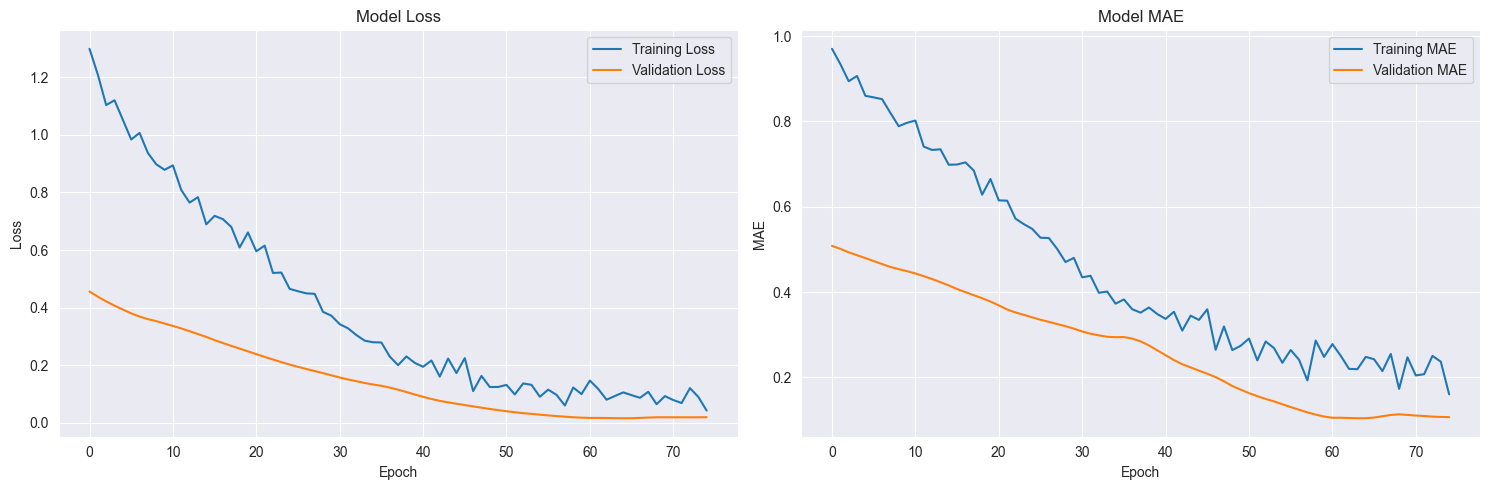

In [24]:
# Visualisasi hasil training
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.show()


In [25]:
# Evaluasi model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test Loss: 0.0096
Test MAE: 0.0819


In [23]:
# Prediksi pada data uji
y_pred_acc = model.predict(X_test)

# Menghitung R²
r2 = r2_score(y_test, y_pred_acc)
print(f'R²: {r2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
R²: 0.9915950911029303


In [26]:
MODEL_DIR = os.path.join("models", "baby_nutrition")

os.makedirs(MODEL_DIR, exist_ok=True)

model_path_h5 = os.path.join(MODEL_DIR, "baby_nutrition_model.h5")
model_path_keras = os.path.join(MODEL_DIR, "baby_nutrition_model.keras")
scaler_x_path = os.path.join(MODEL_DIR, "scaler_X.save")
scaler_y_path = os.path.join(MODEL_DIR, "scaler_y.save")
encoders_path = os.path.join(MODEL_DIR, "encoders.save")

# Save semua komponen
try:
    # Save model dalam 2 format
    model.save(model_path_h5)
    model.save(model_path_keras)
    
    # Save scalers dan encoders
    joblib.dump(scaler_X, scaler_x_path)
    joblib.dump(scaler_y, scaler_y_path)
    joblib.dump(encoders, encoders_path)
    
    print(f"\nModel dan komponen pendukung telah disimpan di {MODEL_DIR}!")

except Exception as e:
    print(f"Error saat menyimpan: {str(e)}")


Model dan komponen pendukung telah disimpan di models\baby_nutrition!


## LOAD MODEL

In [ ]:
# Load model
# model = load_model('/kaggle/working/baby_nutrition_model.h5')
# model = load_model('baby_nutrition_model.keras')

# # Load scaler
# scaler_X = joblib.load('scaler_X.save')
# scaler_y = joblib.load('scaler_y.save')

# # Load encoders
# encoders = joblib.load('encoders.save')

# print("Model, scaler, dan encoders berhasil dimuat!")

MODEL_DIR = os.path.join("models", "baby_nutrition")

# Pastikan folder exists
os.makedirs(MODEL_DIR, exist_ok=True)
model_path_h5 = os.path.join(MODEL_DIR, "baby_nutrition_model.h5")
model_path_keras = os.path.join(MODEL_DIR, "baby_nutrition_model.keras")
scaler_x_path = os.path.join(MODEL_DIR, "scaler_X.save")
scaler_y_path = os.path.join(MODEL_DIR, "scaler_y.save")
encoders_path = os.path.join(MODEL_DIR, "encoders.save")

# Untuk load model nanti:
def load_baby_nutrition_model():
    try:
        # Load model (pilih salah satu format)
        model = load_model(model_path_h5)  # atau model_path_keras
        
        # Load scalers dan encoders
        scaler_X = joblib.load(scaler_x_path)
        scaler_y = joblib.load(scaler_y_path)
        encoders = joblib.load(encoders_path)
        
        return {
            'model': model,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'encoders': encoders
        }
        
    except Exception as e:
        print(f"Error saat loading model: {str(e)}")
        return None

Model, scaler, dan encoders berhasil dimuat!


d:\Development\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [27]:
model.summary()
print(model.input_shape)
print(model.output_shape)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,374 (36.62 KB)

 Trainable params: 3,124 (12.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,250 (24.42 KB)

(None, 6)
(None, 4)


## EXAMPLE

In [1]:
# Fungsi prediksi
def predict_nutrition(usia_bulan, gender, berat_kg, tinggi_cm, aktivitas_level, status_asi):
    # Membuat DataFrame dari input dengan nama kolom yang sesuai
    input_df = pd.DataFrame({
        'Usia_Bulan': [usia_bulan],
        'Gender': [gender],
        'Berat_Kg': [berat_kg],
        'Tinggi_Cm': [tinggi_cm],
        'Aktivitas_Level': [aktivitas_level],
        'Status_ASI': [status_asi]
    })
    
    # Skalasi input
    input_scaled = scaler_X.transform(input_df)
    
    # Prediksi menggunakan model yang sudah dilatih
    pred_scaled = model.predict(input_scaled)
    
    # Invers transformasi output untuk mendapatkan nilai asli
    prediction = scaler_y.inverse_transform(pred_scaled)
    
    return {
        'Kebutuhan_Kalori': max(0, prediction[0][0]),
        'Kebutuhan_Protein': max(0, prediction[0][1]),
        'Kebutuhan_Lemak': max(0, prediction[0][2]),
        'Kebutuhan_Karbohidrat': max(0, prediction[0][3])
    }


In [29]:
def evaluate_daily_intake(predicted_needs, consumed_foods_by_meal, df_food):
    """
    consumed_foods_by_meal harus berupa dictionary dengan format:
    {
        1: ['Makanan1', 'Makanan2'],  # Makan pagi
        2: ['Makanan3', 'Makanan4'],  # Makan siang
        3: ['Makanan5', 'Makanan6']   # Makan malam
    }
    """
    # Inisialisasi total nutrisi yang dikonsumsi
    total_consumed = {
        'calories': 0,
        'proteins': 0,
        'fat': 0,
        'carbohydrate': 0
    }
    
    # Inisialisasi nutrisi per waktu makan
    meals_nutrition = {
        1: {'calories': 0, 'proteins': 0, 'fat': 0, 'carbohydrate': 0, 'foods': []},
        2: {'calories': 0, 'proteins': 0, 'fat': 0, 'carbohydrate': 0, 'foods': []},
        3: {'calories': 0, 'proteins': 0, 'fat': 0, 'carbohydrate': 0, 'foods': []}
    }
    
    # Mapping nama nutrisi Indonesia-Inggris
    nutrient_mapping = {
        'Kalori': 'calories',
        'Protein': 'proteins',
        'Lemak': 'fat',
        'Karbohidrat': 'carbohydrate'
    }
    
    # Hitung nutrisi untuk setiap waktu makan
    for meal_time, foods in consumed_foods_by_meal.items():
        for food_name in foods:
            food_data = df_food[df_food['name'].str.strip().str.lower() == food_name.strip().lower()]
            
            if not food_data.empty:
                food_row = food_data.iloc[0]
                # Tambahkan ke total
                for eng_name in total_consumed.keys():
                    total_consumed[eng_name] += food_row[eng_name]
                    meals_nutrition[meal_time][eng_name] += food_row[eng_name]
                
                # Tambahkan detail makanan
                meals_nutrition[meal_time]['foods'].append({
                    'name': food_name,
                    'calories': food_row['calories'],
                    'proteins': food_row['proteins'],
                    'fat': food_row['fat'],
                    'carbohydrate': food_row['carbohydrate']
                })
            else:
                print(f"WARNING: Makanan '{food_name}' tidak ditemukan dalam database!")
    
    # Hitung persentase pemenuhan kebutuhan
    percentage_fulfilled = {}
    for indo_name, eng_name in nutrient_mapping.items():
        need_key = f'Kebutuhan_{indo_name}'
        if predicted_needs[need_key] > 0:
            percentage_fulfilled[indo_name] = (total_consumed[eng_name] / predicted_needs[need_key]) * 100
        else:
            percentage_fulfilled[indo_name] = 0
    
    # Buat feedback
    feedback = {
        'ringkasan': {},
        'detail_per_meal': meals_nutrition,
        'rekomendasi': []
    }
    
    # Evaluasi setiap nutrisi
    all_within_limits = True
    for indo_name, eng_name in nutrient_mapping.items():
        percentage = percentage_fulfilled[indo_name]
        need_key = f'Kebutuhan_{indo_name}'
        
        upper_limit = 120
        if indo_name == 'Protein':
            upper_limit = 200
        
        if percentage < 80:
            status = "KURANG"
            all_within_limits = False
            selisih = predicted_needs[need_key] - total_consumed[eng_name]
            feedback['rekomendasi'].append(
                f"Asupan {indo_name} masih kurang ({percentage:.1f}%). "
                f"Perlu tambahan {indo_name.lower()} sebesar {selisih:.1f} unit."
            )
        elif 80 <= percentage <= upper_limit:
            status = "IDEAL"
        else:
            status = "BERLEBIH"
            all_within_limits = False
            selisih = total_consumed[eng_name] - predicted_needs[need_key]
            feedback['rekomendasi'].append(
                f"Asupan {indo_name} berlebih ({percentage:.1f}%). "
                f"Kurangi {indo_name.lower()} sebesar {selisih:.1f} unit."
            )
        
        feedback['ringkasan'][indo_name] = {
            'kebutuhan': predicted_needs[need_key],
            'konsumsi': total_consumed[eng_name],
            'persentase': percentage,
            'status': status
        }
    
    if all_within_limits:
        feedback['rekomendasi'].append(
            "Selamat! Asupan nutrisi Anda sudah sangat baik dan seimbang. "
            "Pertahankan pola makan seperti ini untuk kesehatan yang optimal."
        )
    
    return feedback

In [30]:
def print_nutrition_feedback(feedback):
    print("\n" + "="*50)
    print("EVALUASI ASUPAN NUTRISI HARIAN".center(50))
    print("="*50)
    
    print("\nRINGKASAN TOTAL HARIAN:")
    print("-" * 50)
    for nutrient, data in feedback['ringkasan'].items():
        print(f"\n{nutrient}:")
        print(f"Kebutuhan  : {data['kebutuhan']:.1f}")
        print(f"Konsumsi   : {data['konsumsi']:.1f}")
        print(f"Persentase : {data['persentase']:.1f}%")
        print(f"Status     : {data['status']}")
    
    print("\nDETAIL PER WAKTU MAKAN:")
    print("-" * 50)
    meal_names = {1: "PAGI", 2: "SIANG", 3: "MALAM"}
    
    for meal_time, meal_data in feedback['detail_per_meal'].items():
        print(f"\nMAKAN {meal_names[meal_time]}:")
        print(f"Kalori     : {meal_data['calories']:.1f}")
        print(f"Protein    : {meal_data['proteins']:.1f}")
        print(f"Lemak      : {meal_data['fat']:.1f}")
        print(f"Karbohidrat: {meal_data['carbohydrate']:.1f}")
        
        print("\nMakanan yang dikonsumsi:")
        for food in meal_data['foods']:
            print(f"- {food['name']}")
    
    print("\nREKOMENDASI:")
    print("-" * 50)
    if feedback['rekomendasi']:
        for rekomendasi in feedback['rekomendasi']:
            print(f"- {rekomendasi}")

In [31]:
def extract_age_range(age_group):
    # Mengambil angka dari string age group
    numbers = re.findall(r'\d+', age_group)
    if len(numbers) >= 2:
        return int(numbers[0]), int(numbers[1])
    return 0, 0

def is_age_appropriate(food_age_group, baby_age_months):
    start_age, end_age = extract_age_range(food_age_group)
    return start_age <= baby_age_months <= end_age

In [32]:
def recommend_foods(predicted_needs, df_food, baby_age_months, max_items=3, meals_per_day=3):
    # Filter makanan berdasarkan umur
    df_food_filtered = df_food[df_food['Age_Group'].apply(lambda x: is_age_appropriate(x, baby_age_months))].copy()
    
    # Jika bayi masih ASI (dibawah 6 bulan), berikan rekomendasi khusus
    if baby_age_months <= 6:
        return recommend_exclusive_breastfeeding(predicted_needs)
    
    # Bagi kebutuhan nutrisi per hari menjadi 3 kali makan
    target_per_meal = {
        'calories': predicted_needs['Kebutuhan_Kalori'] / meals_per_day,
        'proteins': predicted_needs['Kebutuhan_Protein'] / meals_per_day,
        'fat': predicted_needs['Kebutuhan_Lemak'] / meals_per_day,
        'carbs': predicted_needs['Kebutuhan_Karbohidrat'] / meals_per_day
    }
    
    # Buat problem optimasi untuk setiap waktu makan
    meal_recommendations = []
    for meal_num in range(meals_per_day):
        prob = LpProblem(f"Food_Recommendation_Meal_{meal_num}", LpMinimize)
        
        # Buat variabel keputusan untuk setiap makanan (0 atau 1)
        food_vars = LpVariable.dicts("food",
                                   ((i) for i in range(len(df_food_filtered))),
                                   0, 1, LpBinary)
        
        # Variabel deviasi
        pos_dev_cal = LpVariable(f"pos_dev_cal_{meal_num}", 0)
        neg_dev_cal = LpVariable(f"neg_dev_cal_{meal_num}", 0)
        
        # Fungsi objektif
        prob += pos_dev_cal + neg_dev_cal
        
        # Constraints
        prob += lpSum([df_food_filtered.iloc[i]['calories'] * food_vars[i] 
                      for i in range(len(df_food_filtered))]) - target_per_meal['calories'] == pos_dev_cal - neg_dev_cal
        
        # Batasan jumlah item
        prob += lpSum([food_vars[i] for i in range(len(df_food_filtered))]) >= 1
        prob += lpSum([food_vars[i] for i in range(len(df_food_filtered))]) <= max_items
        
        # Batasan nutrisi per meal
        prob += lpSum([df_food_filtered.iloc[i]['calories'] * food_vars[i] 
                      for i in range(len(df_food_filtered))]) >= 0.8 * target_per_meal['calories']
        prob += lpSum([df_food_filtered.iloc[i]['calories'] * food_vars[i] 
                      for i in range(len(df_food_filtered))]) <= 1.2 * target_per_meal['calories']
        
        # Solve
        prob.solve(PULP_CBC_CMD(msg=False))
        
        # Collect results
        meal_foods = []
        meal_nutrients = {
            'calories': 0,
            'proteins': 0,
            'fat': 0,
            'carbohydrate': 0
        }
        
        for i in range(len(df_food_filtered)):
            if food_vars[i].value() == 1:
                food = {
                    'name': df_food_filtered.iloc[i]['name'],
                    'calories': df_food_filtered.iloc[i]['calories'],
                    'proteins': df_food_filtered.iloc[i]['proteins'],
                    'fat': df_food_filtered.iloc[i]['fat'],
                    'carbohydrate': df_food_filtered.iloc[i]['carbohydrate'],
                    'age_group': df_food_filtered.iloc[i]['Age_Group']
                }
                meal_foods.append(food)
                
                for nutrient in meal_nutrients:
                    meal_nutrients[nutrient] += food[nutrient]
        
        meal_recommendations.append({
            'meal_number': meal_num + 1,
            'foods': meal_foods,
            'nutrients': meal_nutrients
        })
    
    # Calculate total nutrients
    total_nutrients = {
        'calories': 0,
        'proteins': 0,
        'fat': 0,
        'carbohydrate': 0
    }
    
    for meal in meal_recommendations:
        for nutrient in total_nutrients:
            total_nutrients[nutrient] += meal['nutrients'][nutrient]
    
    return {
        'meal_recommendations': meal_recommendations,
        'total_nutrients': total_nutrients,
        'target_nutrients': predicted_needs,
        'age_months': baby_age_months
    }

def recommend_exclusive_breastfeeding(predicted_needs):
    # Rekomendasi khusus untuk bayi di bawah 6 bulan
    return {
        'meal_recommendations': [
            {
                'meal_number': i + 1,
                'foods': [{'name': 'ASI', 'portion': 'On demand'}],
                'nutrients': {
                    'calories': predicted_needs['Kebutuhan_Kalori'] / 3,
                    'proteins': predicted_needs['Kebutuhan_Protein'] / 3,
                    'fat': predicted_needs['Kebutuhan_Lemak'] / 3,
                    'carbohydrate': predicted_needs['Kebutuhan_Karbohidrat'] / 3
                }
            } for i in range(3)
        ],
        'total_nutrients': {
            'calories': predicted_needs['Kebutuhan_Kalori'],
            'proteins': predicted_needs['Kebutuhan_Protein'],
            'fat': predicted_needs['Kebutuhan_Lemak'],
            'carbohydrate': predicted_needs['Kebutuhan_Karbohidrat']
        },
        'target_nutrients': predicted_needs,
        'age_months': 'Under 6 months'
    }

# Fungsi untuk menampilkan rekomendasi
def display_recommendations(recommendations):
    print(f"\nRekomendasi Makanan untuk Usia {recommendations['age_months']} bulan:")
    print("\nTarget Nutrisi Harian:")
    print(f"Kalori: {recommendations['target_nutrients']['Kebutuhan_Kalori']:.1f} kcal")
    print(f"Protein: {recommendations['target_nutrients']['Kebutuhan_Protein']:.1f} g")
    print(f"Lemak: {recommendations['target_nutrients']['Kebutuhan_Lemak']:.1f} g")
    print(f"Karbohidrat: {recommendations['target_nutrients']['Kebutuhan_Karbohidrat']:.1f} g")
    
    print("\nRekomendasi per Waktu Makan:")
    for meal in recommendations['meal_recommendations']:
        print(f"\nMakan ke-{meal['meal_number']}:")
        for food in meal['foods']:
            print(f"- {food['name']}")
            if 'portion' in food:
                print(f"  Porsi: {food['portion']}")
            else:
                print(f"  Kalori: {food['calories']:.1f} kcal")
                print(f"  Protein: {food['proteins']:.1f} g")
                print(f"  Lemak: {food['fat']:.1f} g")
                print(f"  Karbohidrat: {food['carbohydrate']:.1f} g")
    
    print("\nTotal Nutrisi dari Rekomendasi:")
    if isinstance(recommendations['total_nutrients'], dict):
        print(f"Kalori: {recommendations['total_nutrients']['calories']:.1f} kcal")
        print(f"Protein: {recommendations['total_nutrients']['proteins']:.1f} g")
        print(f"Lemak: {recommendations['total_nutrients']['fat']:.1f} g")
        print(f"Karbohidrat: {recommendations['total_nutrients']['carbohydrate']:.1f} g")
    else:
        print(f"Kalori: {recommendations['total_nutrients']['Kebutuhan_Kalori']:.1f} kcal")
        print(f"Protein: {recommendations['total_nutrients']['Kebutuhan_Protein']:.1f} g")
        print(f"Lemak: {recommendations['total_nutrients']['Kebutuhan_Lemak']:.1f} g")
        print(f"Karbohidrat: {recommendations['total_nutrients']['Kebutuhan_Karbohidrat']:.1f} g")

In [33]:
# Contoh penggunaan:
usia_bayi=12
# Prediksi kebutuhan nutrisi
sample_prediction = predict_nutrition(
    usia_bulan=usia_bayi,
    gender=1,
    berat_kg=9,
    tinggi_cm=74,
    aktivitas_level=1,
    status_asi=1
)


# 460,9.5,32,49
# sample_prediction = predict_nutrition(
#     usia_bulan=usia_bayi,
#     gender=1,
#     berat_kg=4,
#     tinggi_cm=53,
#     aktivitas_level=1,
#     status_asi=1
# )

consumed_foods_by_meal = {
    1: ['Nasi Tim Saring', 'Bubur Ayam Saring', 'Pure Kentang'],  # Makan pagi
    2: ['Nasi Tim Saring', 'Pure Kentang'],                # Makan siang
    3: ['Nasi Tim Saring', 'Bubur Ayam Saring', ]    # Makan malam
}

feedback = evaluate_daily_intake(sample_prediction, consumed_foods_by_meal, df_food)
print_nutrition_feedback(feedback)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

          EVALUASI ASUPAN NUTRISI HARIAN          

RINGKASAN TOTAL HARIAN:
--------------------------------------------------

Kalori:
Kebutuhan  : 885.5
Konsumsi   : 725.0
Persentase : 81.9%
Status     : IDEAL

Protein:
Kebutuhan  : 19.5
Konsumsi   : 19.3
Persentase : 99.1%
Status     : IDEAL

Lemak:
Kebutuhan  : 62.0
Konsumsi   : 6.1
Persentase : 9.8%
Status     : KURANG

Karbohidrat:
Kebutuhan  : 97.0
Konsumsi   : 148.0
Persentase : 152.6%
Status     : BERLEBIH

DETAIL PER WAKTU MAKAN:
--------------------------------------------------

MAKAN PAGI:
Kalori     : 301.0
Protein    : 8.6
Lemak      : 2.9
Karbohidrat: 60.0

Makanan yang dikonsumsi:
- Nasi Tim Saring
- Bubur Ayam Saring
- Pure Kentang

MAKAN SIANG:
Kalori     : 200.0
Protein    : 4.1
Lemak      : 0.4
Karbohidrat: 45.0

Makanan yang dikonsumsi:
- Nasi Tim Saring
- Pure Kentang

MAKAN MALAM:
Kalori     : 224.0
Protein    : 6.6
Lemak      : 2.8
Karbohidrat: 43.0

Makanan yang dikonsum

In [34]:
recommendations = recommend_foods(sample_prediction, df_food, baby_age_months=usia_bayi)
display_recommendations(recommendations)


Rekomendasi Makanan untuk Usia 12 bulan:

Target Nutrisi Harian:
Kalori: 885.5 kcal
Protein: 19.5 g
Lemak: 62.0 g
Karbohidrat: 97.0 g

Rekomendasi per Waktu Makan:

Makan ke-1:
- Tim Ikan Giling
  Kalori: 74.0 kcal
  Protein: 16.0 g
  Lemak: 1.0 g
  Karbohidrat: 0.0 g
- Oatmeal Bayi
  Kalori: 71.0 kcal
  Protein: 2.4 g
  Lemak: 1.4 g
  Karbohidrat: 12.0 g
- Bubur Pisang Keju
  Kalori: 150.0 kcal
  Protein: 3.5 g
  Lemak: 4.5 g
  Karbohidrat: 22.0 g

Makan ke-2:
- Tim Ikan Giling
  Kalori: 74.0 kcal
  Protein: 16.0 g
  Lemak: 1.0 g
  Karbohidrat: 0.0 g
- Oatmeal Bayi
  Kalori: 71.0 kcal
  Protein: 2.4 g
  Lemak: 1.4 g
  Karbohidrat: 12.0 g
- Bubur Pisang Keju
  Kalori: 150.0 kcal
  Protein: 3.5 g
  Lemak: 4.5 g
  Karbohidrat: 22.0 g

Makan ke-3:
- Tim Ikan Giling
  Kalori: 74.0 kcal
  Protein: 16.0 g
  Lemak: 1.0 g
  Karbohidrat: 0.0 g
- Oatmeal Bayi
  Kalori: 71.0 kcal
  Protein: 2.4 g
  Lemak: 1.4 g
  Karbohidrat: 12.0 g
- Bubur Pisang Keju
  Kalori: 150.0 kcal
  Protein: 3.5 g
  Lem

In [35]:
!pip install pipreqs